In [58]:
!pip install pandas numpy matplotlib scikit-learn statsmodels pytrends

In [59]:
from pytrends.request import TrendReq

# Initialize pytrends
pytrends = TrendReq(hl='en-US', tz=360)

In [60]:
import pandas as pd

# Define the keyword
kw_list = ["laptops"]

# Build the payload
pytrends.build_payload(kw_list, cat=0, timeframe='today 5-y', geo='', gprop='')

# Fetch the interest over time
data = pytrends.interest_over_time()

# Remove unnecessary columns
data = data.drop(labels=['isPartial'], axis=1)

# Display the data
print(data.head())

            laptops
date               
2019-12-01       73
2019-12-08       58
2019-12-15       58
2019-12-22       62
2019-12-29       54


/usr/local/lib/python3.10/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


In [61]:
# Check for missing values
data = data.dropna()

# Reset the index
data = data.reset_index()

# Rename columns
data.columns = ['Date', 'Interest']

# Convert 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set 'Date' as the index
data.set_index('Date', inplace=True)

In [62]:
from statsmodels.tsa.arima.model import ARIMA

# Split the data into training and testing sets
train = data[:int(0.8*(len(data)))]
test = data[int(0.8*(len(data))):]

# Build the ARIMA model
model = ARIMA(train['Interest'], order=(5, 1, 0))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               Interest   No. Observations:                  209
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -622.707
Date:                Thu, 05 Dec 2024   AIC                           1257.413
Time:                        05:58:43   BIC                           1277.439
Sample:                    12-01-2019   HQIC                          1265.511
                         - 11-26-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2569      0.056     -4.550      0.000      -0.368      -0.146
ar.L2         -0.0679      0.060     -1.128      0.259      -0.186       0.050
ar.L3         -0.1485      0.061     -2.450      0.0

Mean Absolute Error: 6.741123542434711


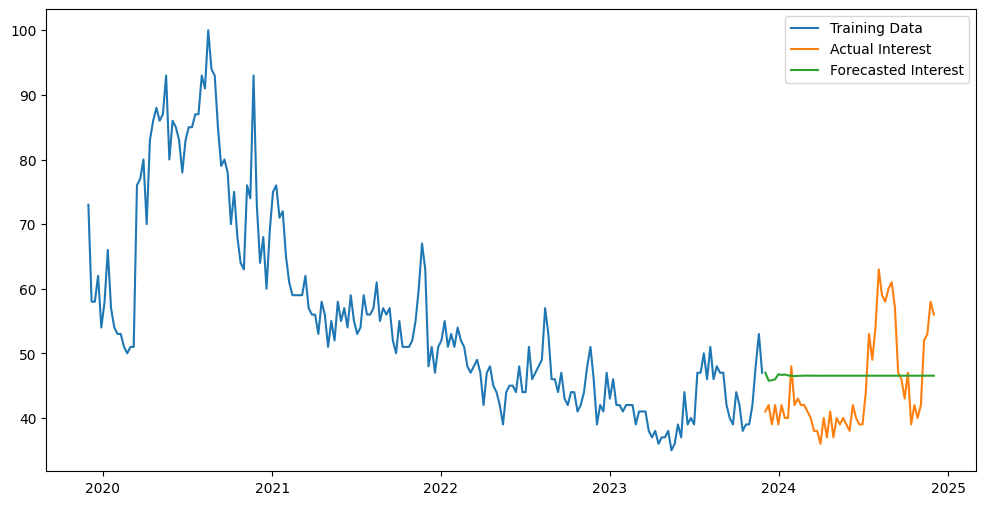

In [63]:
import numpy as np

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Evaluate the model
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test['Interest'], forecast)
print(f'Mean Absolute Error: {mae}')

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(train['Interest'], label='Training Data')
plt.plot(test['Interest'], label='Actual Interest')
plt.plot(forecast, label='Forecasted Interest')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


            Forecasted_Interest
Date                           
2024-12-01            55.353725
2025-01-01            54.271200
2025-02-01            54.351834
2025-03-01            54.254619
2025-04-01            54.574147
2025-05-01            54.612911
2025-06-01            54.670118
2025-07-01            54.620861
2025-08-01            54.609864
2025-09-01            54.583798
2025-10-01            54.589201
2025-11-01            54.589756


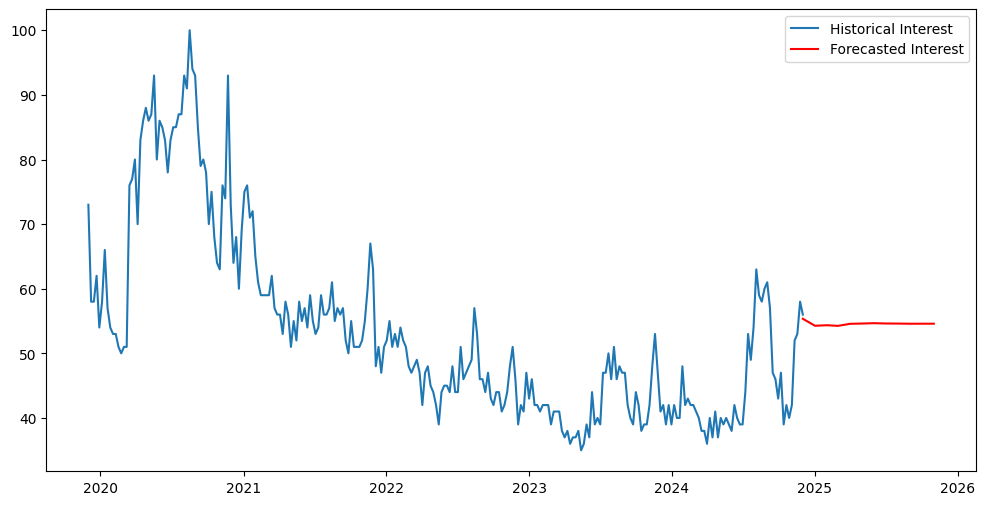

In [64]:
# Refit the model on the entire dataset
model = ARIMA(data['Interest'], order=(5, 1, 0))
model_fit = model.fit()

# Forecast the next 12 months
forecast = model_fit.forecast(steps=12)

# Create a date range for the forecast
future_dates = pd.date_range(start=data.index[-1], periods=12, freq='MS')

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'Date': future_dates, 'Forecasted_Interest': forecast})
forecast_df.set_index('Date', inplace=True)

# Display the forecast
print(forecast_df)

# Plot the forecast
plt.figure(figsize=(12,6))
plt.plot(data['Interest'], label='Historical Interest')
plt.plot(forecast_df['Forecasted_Interest'], label='Forecasted Interest', color='red')
plt.legend()
plt.show()

In [66]:
import pandas as pd
import time
from datetime import datetime
import smtplib
from email.mime.text import MIMEText

def analyze_trends_with_volume(keyword, buy_threshold=70, max_volume=1000):
    """
    Analyze Google Trends data and suggest buy/sell volume.

    Args:
        keyword (str): The product keyword.
        buy_threshold (int): Threshold for triggering a buy suggestion.
        max_volume (int): Maximum volume to buy.

    Returns:
        dict: Analysis results with volume suggestion.
    """
    # Initialize pytrends
    pytrends = TrendReq(hl='en-US', tz=360)

    # Build payload
    pytrends.build_payload([keyword], cat=0, timeframe='today 5-y', geo='', gprop='')

    # Fetch interest over time
    data = pytrends.interest_over_time()
    if 'isPartial' in data.columns:
        data = data.drop(['isPartial'], axis=1)

    # Check if enough data is available
    if data.empty:
        return "No data available for the given keyword."

    # Calculate moving average (7-day)
    data['7_day_MA'] = data[keyword].rolling(window=7).mean()

    # Check for buying signal
    latest_value = data[keyword].iloc[-1]
    signal = "BUY" if latest_value > buy_threshold else "HOLD"

    # Suggest volume
    if signal == "BUY":
        # Calculate volume proportionally to the interest level
        volume = int((latest_value / 100) * max_volume)
    else:
        # Suggest selling a fraction if the trend is below the threshold
        volume = int(-(latest_value / 100) * max_volume / 2)

    # Ensure volume bounds
    volume = max(min(volume, max_volume), -max_volume)

    return {
        "current_interest": latest_value,
        "signal": signal,
        "volume_suggestion": volume,
        "trend_data": data
    }

# Example of running the analysis
result = analyze_trends_with_volume("laptops", buy_threshold=70, max_volume=1000)
if isinstance(result, str):
    print(result)
else:
    print(f"Interest: {result['current_interest']}, Signal: {result['signal']}, Volume: {result['volume_suggestion']}")

Interest: 54, Signal: HOLD, Volume: -270


/usr/local/lib/python3.10/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
